# Event data and VAE performance analysis - June 01, 2019

In [1]:
# Python library and module imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py
import torch

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Import the custom plotting module
from plot_utils import plot_utils

# 1. Event visualization for the VAE reconstructions

In [12]:
# Path to a sample event vs reconstruction file
np_arr_dir = "/home/akajal/WatChMaL/WatChMaL-VAE/USER/save_path_vae/data_description/"
np_arr_path = np_arr_dir + "20190602_001440/event_vs_recon_iteration_1589999.npz"

# Load the numpy array
np_arr = np.load(np_arr_path)
np_event = np_arr["event"]
np_recon = np_arr["recon"]

print(np_event.shape)
print(np_recon.shape)

(32, 16, 40, 19)
(32, 16, 40, 19)


In [3]:
"""
Script for transforming 19-layer mPMT data into a pixel grid array for matplotlib

Author: Julian Ding
"""

import numpy as np

# 10x10 square represents one mPMT
# List of top-left pixel positions (row,col) for 2x2 grids representing PMTs 0 to 18
POS_MAP = [(8,4), #0
           (7,2), #1
           (6,0), #2
           (4,0), #3
           (2,0), #4
           (1,1), #5
           (0,4), #6
           (1,6), #7
           (2,8), #8
           (4,8), #9
           (6,8), #10
           (7,6), #11
           # Inner ring
           (6,4), #12
           (5,2), #13
           (3,2), #14
           (2,4), #15
           (3,6), #16
           (5,6), #17
           (4,4)] #18

PADDING = 0

def get_plot_array(event_data):
    
    # Assertions on the shape of the data and the number of input channels
    assert(len(event_data.shape) == 3 and event_data.shape[2] == 19)
    
    # Extract the number of rows and columns from the event data
    rows = event_data.shape[0]
    cols = event_data.shape[1]
    
    # Make empty output pixel grid
    output = np.zeros(((10+PADDING)*rows, (10+PADDING)*cols))
    
    i, j = 0, 0
    
    for row in range(rows):
        j = 0
        for col in range(cols):
            pmts = event_data[row, col]
            tile(output, (i, j), pmts)
            j += 10 + PADDING
        i += 10 + PADDING
        
    return output
            
def tile(canvas, ul, pmts):
    
    # First, create 10x10 grid representing single mpmt
    mpmt = np.zeros((10, 10))
    for i, val in enumerate(pmts):
        mpmt[POS_MAP[i][0]][POS_MAP[i][1]] = val

    # Then, place grid on appropriate position on canvas
    for row in range(10):
        for col in range(10):
            canvas[row+ul[0]][col+ul[1]] = mpmt[row][col]

In [4]:
# Plot the reconstructed vs actual events
def plot_actual_vs_recon(actual_event=None, recon_event=None, show_plot=False, save_path=None):
    """
    plot_actual_vs_event(actual_event=None, recon_event=None, show_plot=)
                           
    Purpose : Plot the actual event vs event reconstructed by the VAE
    
    Args: actual_event        ... 3-D NumPy array with the event data, shape=(width, height, depth)
          recon_event         ... 3-D NumPy array with the reconstruction data, shape = (width, height, depth)
          show_plot[optional] ... Boolean to determine whether to show the plot, default=False
          save_path[optional] ... Path to save the plot to, format='eps', default=None
    """
    
    # Assertions
    assert actual_event.any() != None
    assert recon_event.any() != None
    assert len(actual_event.shape) == 3
    assert len(recon_event.shape) == 3
    
    # Initialize the figure to plot the events
    fig, axes = plt.subplots(2,1,figsize=(32,18))
    plt.subplots_adjust(hspace=0.2)
    
    # Setup the plot
    axes[0].imshow(get_plot_array(actual_event))
    axes[0].set_title("Actual event display", fontsize=20)
    axes[0].set_xlabel("PMT module X-position", fontsize=20)
    axes[0].set_ylabel("PMT module Y-position", fontsize=20)
    axes[0].grid(True, which="both", axis="both")
    
    axes[1].imshow(get_plot_array(recon_event))
    axes[1].set_title("Reconstructed event display", fontsize=20)
    axes[1].set_xlabel("PMT module X-position", fontsize=20)
    axes[1].set_ylabel("PMT module Y-position", fontsize=20)
    axes[1].grid(True, which="both", axis="both")
    
    if save_path is not None:
        plt.savefig(save_path, format='eps', dpi=300)
    
    if show_plot:
        plt.show()
    else:
        plt.clf() # Clear the plot frame
        plt.close() # Close the opened window if any

In [5]:
"""# Select the event to display
event = np_event[16,:,:,:]
recon = np_recon[16,:,:,:]

event_tensor = torch.from_numpy(event)
recon_tensor = torch.from_numpy(recon)

print(event_tensor.size())
print(recon_tensor.size())

event_tensor = event_tensor.permute(1,2,0)
recon_tensor = recon_tensor.permute(1,2,0)

print(event_tensor.size())
print(recon_tensor.size())

event = event.reshape(event.shape[1], event.shape[2], event.shape[0])
recon = recon.reshape(recon.shape[1], recon.shape[2], recon.shape[0])

event = event[:,:,:19]
recon = recon[:,:,:19]

print(event.shape)
print(recon.shape)"""

torch.Size([16, 40, 19])
torch.Size([16, 40, 19])
torch.Size([40, 19, 16])
torch.Size([40, 19, 16])


'\nevent = event.reshape(event.shape[1], event.shape[2], event.shape[0])\nrecon = recon.reshape(recon.shape[1], recon.shape[2], recon.shape[0])\n\nevent = event[:,:,:19]\nrecon = recon[:,:,:19]\n\nprint(event.shape)\nprint(recon.shape)'

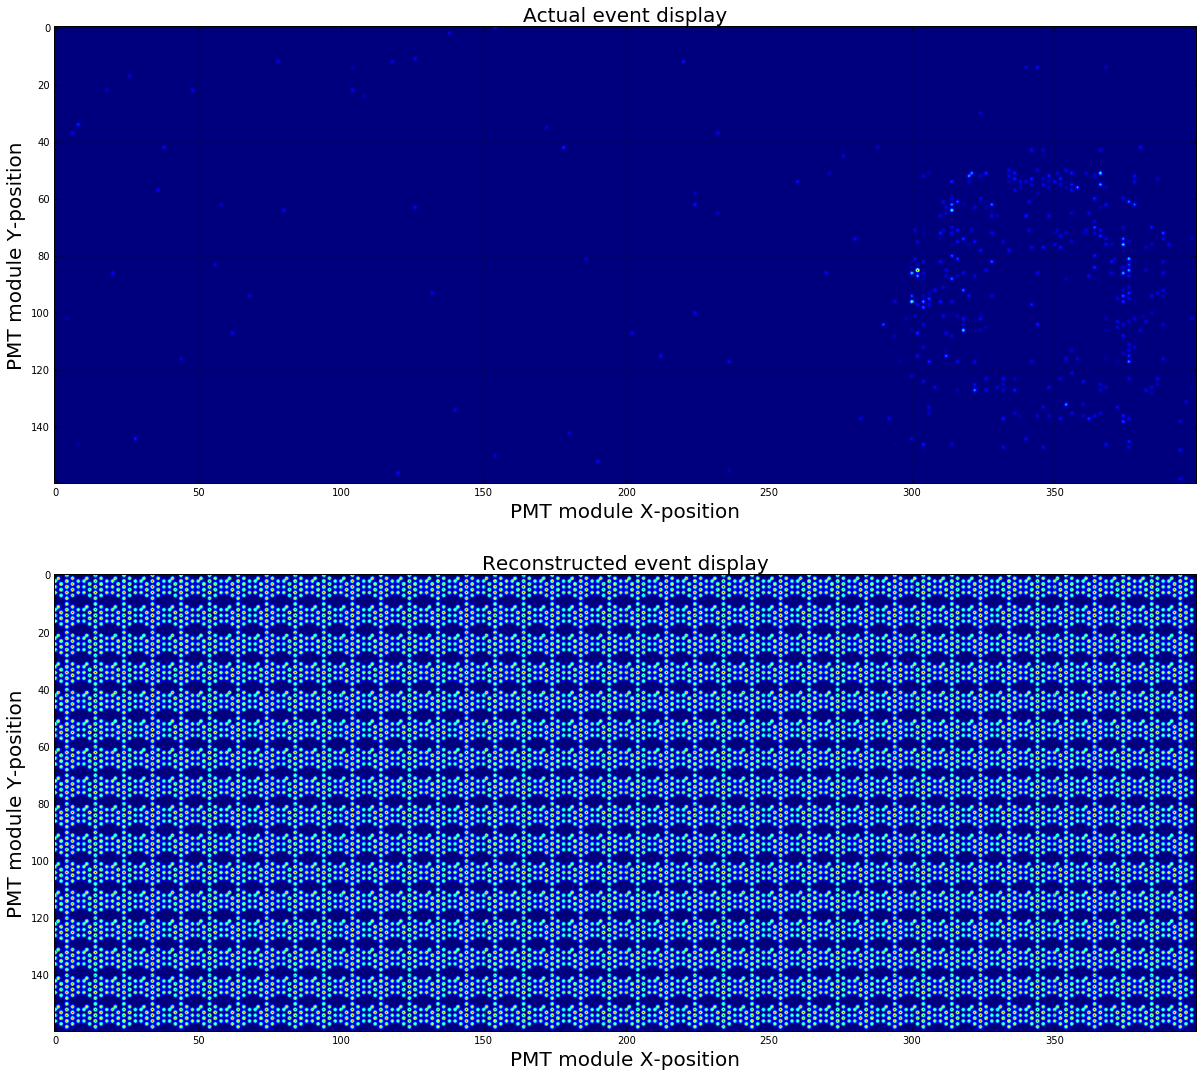

In [14]:
event = np_event[0,:,:,:19]
recon = np_recon[0,:,:,:19]


plot_actual_vs_recon(event, recon, show_plot=True)

In [61]:
h5 = h5py.File("/fast_scratch/WatChMaL/data/IWCDmPMT/varyE/IWCDmPMT_varyE_100-1000MeV_300k_fmt.h5")
print(h5.keys())

<KeysViewHDF5 ['energies', 'event_data', 'labels', 'positions']>


In [62]:
h5_events = h5['event_data']
print(h5_events.shape)

(900000, 16, 40, 38)


In [66]:
print(h5_events[0,:,:,:19].shape)

(16, 40)


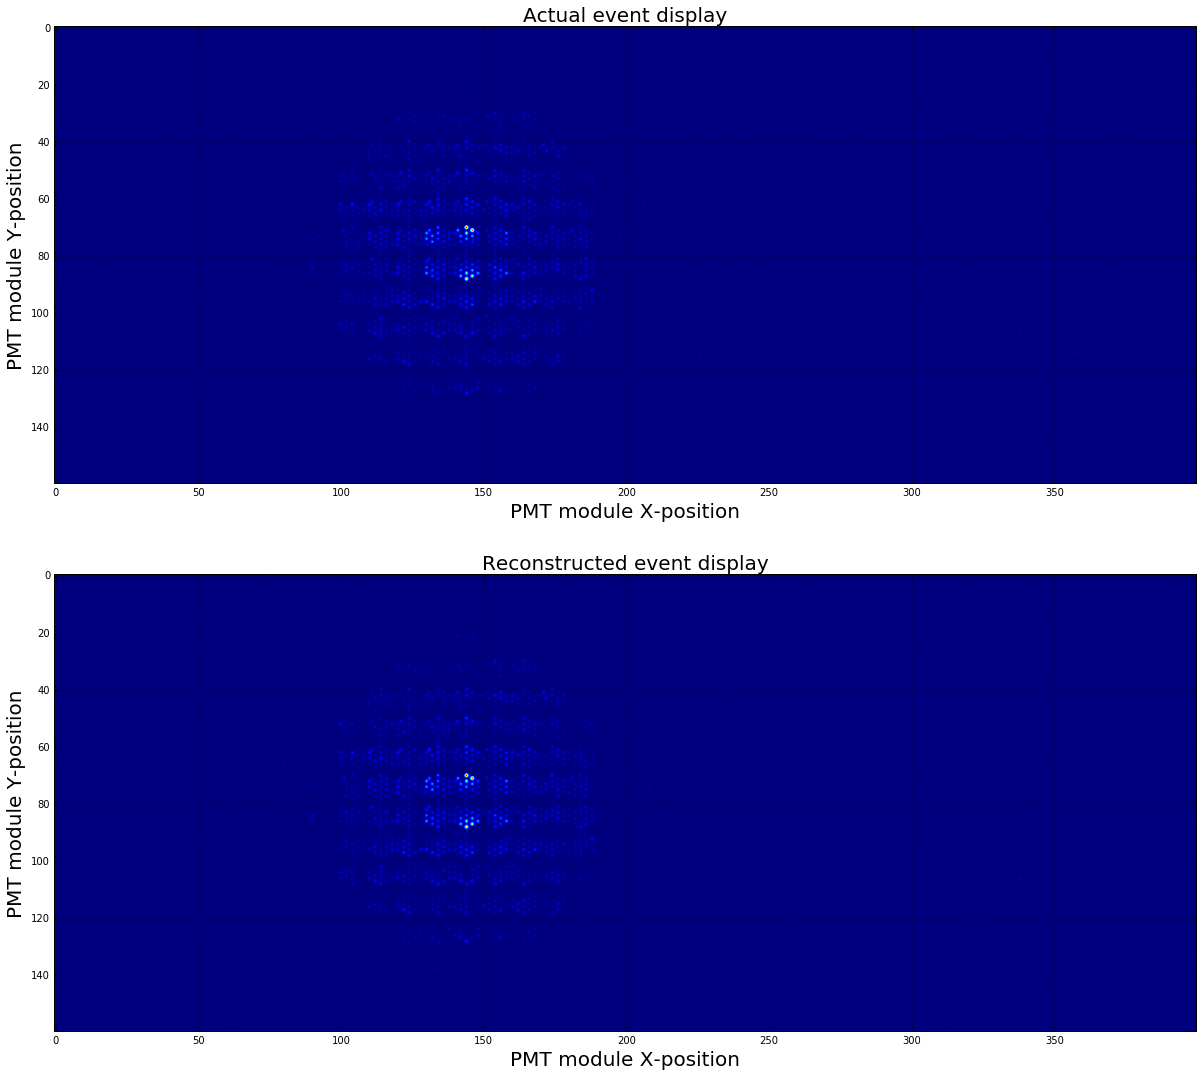

In [76]:
plot_actual_vs_recon(h5_events[15,:,:,:19], h5_events[15,:,:,:19], show_plot=True)

# Visualizing the charge and timing distribution